# Fixed Bias Sampler

Gibbs sampler for the reporter model where each weekday is assigned a fixed reporting bias $\alpha_{w[t]}$, which does not vary over time and is independant of other days. This deterministically scales the true case/death number on each day to give the recorded count.

## Fixed Bias Formulation

The simplest form of this formulation is when $C_{t} = \alpha_{w[t]} I_{t}$ - i.e. the ground truth cases are scaled by some weekday-dependant scalar constant to give the observed cases - this means we have full knowledge of the true values if we learn the reporting biases, and so need not learn the true values separately.

We must however learn the time-varying $R_{t}$ values, as well as the weekday biases $\alpha_{w[t]}$, in two steps.

**Firstly** the reproduction value $R_{t}$ is sampled for every timestep $t$. We use a sliding window to assume $R_{t}$ has been constant for the previous 7 days. This gives the following conditional probability (derived in `varying_Rt_sampler.ipynb`), based on the prior $Gamma(a_{R}, b_{R})$:

$$
P(R_{t} | I_{t}) \propto Gamma \Biggl(a_{R} + \sum_{t'=t-6}^{t} I_{t'}, b_{R} + \sum_{t'=t-6}^{t}\Lambda_{t'} \Biggr) 
$$


**Secondly**, $\alpha_{i}$ are updated using Gibbs sampling from the following conditional probability:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{1, 8, 15, ...} Po(C_{t} | \alpha_{i} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

summing over all days of that given weekday (monday indicies illustrated). This may be simplified to a single Gamma distribution using a known conditional prior relation (noting that the rates of the two processes differ by a scalar $I_{t}$ and so this is not quite equal to the standard relation). The prior of $\alpha_{i}$ is given by a Gamma distribution $Gamma(a, b)$.


### Conjugate Priors for $\alpha_{i}$

As above, the conditional posterior for $\alpha_{i}$ is given by:

$$
P(\alpha_{i[t]} | C_{t}, R_{t}) = P(C_{t} | \alpha_{i[t]}, R_{t}) \times P(\alpha_{i}) = \prod_{t}  Po(C_{t} / \alpha_{i[t]} | R_{t} \Lambda_{t}) \times Gamma(\alpha_{i[t]} | a, b)
$$

where we only consider times corresponding to a single weekday (i.e. $t = {1, 8, 15...}$ for $i = 1$). 

We know that $P(I_{t} | R_{t}) \sim Po(I_{t} | R_{t} \Lambda_{t})$ and so therefore $P(C_{t} | R_{t}) \sim Po(C_{t} / \alpha_{i[t]} | R_{t} \Lambda_{t})$. This is equivalent to a scaled poisson distribution; i.e. $Po(C_{t} | R_{t} \Lambda_{t} \alpha_{i[t]})$ (***I think!***)

$$
P(\alpha_{i[t]} | C_{t}, R_{t}) = \prod_{t}  Po(C_{t} | R_{t} \Lambda_{t} \alpha_{i[t]}) \times Gamma(\alpha_{i[t]} | a, b)
$$

This product may be written as:

$$
\prod_{t} Po(C_{t} | R_{t} \Lambda_{t} \alpha_{i[t]} ) = \prod_{t} (R_{t} \Lambda_{t} \alpha_{i[t]})^{C_{t}} \times \frac{e^{-R_{t} \Lambda_{t} \alpha_{i[t]}}}{C_{t}!}
$$

which we may simplify to (removing the constant factorial $C_{t}!$ and the multiplicative constant $\prod_{t}\left[ R_{t} \Lambda_{t}\right]^{C_{t}}$):

$$
\prod_{t} Po(C_{t} | R_{t} \Lambda_{t} \alpha_{i[t]} ) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}R_{t}\Lambda_{t}} 
$$

Combining this with the explicit form of the gamma prior, we may therefore write that:


$$
P(\alpha_{i[t]} | C_{t}, R_{t}) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}R_{t}\Lambda_{t}} \times \alpha_{i[t]} \! ^{a-1} \times e^{-b\alpha_{i[t]}}
$$


Collecting like terms, and removing the multiplicative constant $\prod_{t} I_{t}^{C_{t}}$, we arrive at the final result:

$$
P(\alpha_{i[t]} | C_{t}, R_{t}) \propto \alpha_{i[t]} \! ^{(a + \sum_{t=i}^{n}C_{t}) -1} \times e^{-\alpha_{i[t]} \left(b + \sum_{t=i}^{n}R_{t}\Lambda_{t}\right)} 
$$


which is in the form of a Gamma distribution:

$$
P(\alpha_{i[t]} | C_{t}, R_{t}) \sim Gamma \left(a + \sum_{t=i}^{n}C_{t}, b + \sum_{t=i}^{n}R_{t}\Lambda_{t} \right)
$$


## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from synthetic_data import RenewalModel, Reporter

In [2]:
# Simulate Renewal Model
time_steps = 100; N_0 = 100; seed=41; R0_diff = 0.2
start_date = '01/01/2020'; bias_method = 'poisson'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
images_path = "synthetic_inference/stepped_R/"

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

100%|██████████| 100/100 [00:00<00:00, 127370.30it/s]


In [3]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

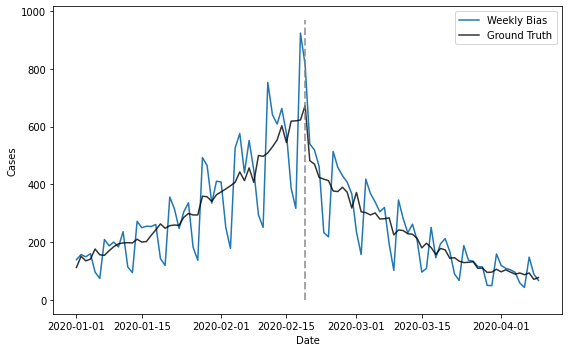

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
plt.vlines(x=mid_date, ymin=0, ymax=plt.gca().get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_data_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_seed_{seed}.png")

## Posterior Distribution Generation
In this section, we apply the above formulation to conduct inference.

In [5]:
from sampling_methods import GibbsParameter, MixedSampler
from periodic_model import truth_parameter, scale_bias_parameter, rt_parameter

In [7]:
I_data = list(bias_df['Confirmed'])

params = {'bias_prior_alpha': 1, 'bias_prior_beta': 1,
          'rt_prior_alpha': 1, 'rt_prior_beta': 1}  # Gamma dist

params['serial_interval'] = RenewalModel(R0=None).serial_interval
params['Rt_window'] = 7  # Assume it is constant for 7 days

for i, val in enumerate(I_data):  # Observed cases - not a Parameter
    params[("data_" + str(i))] = val

for i in range(7):  # Weekday bias parameters
    params[("bias_" + str(i))] = scale_bias_parameter(1, index=i)

for i in range(0, len(I_data)):  # Reproductive number values
    params[("R_" + str(i))] = rt_parameter(value=1, index=i)

step_num = 2000
sampler = MixedSampler(params=params)
output = sampler.sampling_routine(step_num=step_num, sample_burnin=0)

filename = f"synth_inference_T_{bias_method}_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.csv"
output.to_csv('../data/outputs/scale_bias_model/' + filename)

images_path = "synthetic_inference/stepped_R/scale_bias_model/"

100%|██████████| 50/50 [00:01<00:00, 27.11it/s]


In [ ]:
# # Read in old dataset

# output = pd.read_csv("../data/outputs/synth_inference_T_poisson_600_N0_100_R0_0.99_It_300_seed_32.csv")
# bias_method = 'scale'; time_steps = 600; N_0 = 100; R_0 = 0.99; step_num = 300; seed = 32
# if 'R_t' in output.columns:  # Backward compatibility
#     output['R_0'] = output['R_t']

# np.random.seed(seed); model = RenewalModel(R0=R_0); model.simulate(T=time_steps, N_0=N_0)

# rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease
# truth_df = rep.unbiased_report(); bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

# images_path = "synthetic_inference/stepped_R/multichain/variable_sampling_rate/"

## Output Visualisation

Mean bias values: [0.3, 1.0, 0.8, 0.7, 0.7, 0.6, 0.4]
True bias values: [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]


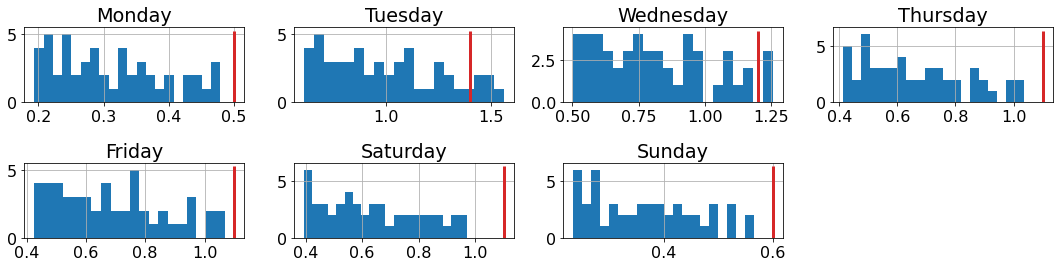

In [8]:
plt.rcParams['font.size'] = '16'

start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday()
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=20, figsize=(15, 4), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biases_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seeds_{seed}.png")

print("Mean bias values: " + str(output_bias))
print(f"True bias values: {bias}")

In [9]:
for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 2)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 2)
    print(f"Bias_{i}: {mean} +/- {std}")

Bias_0: 0.31 +/- 0.08
Bias_1: 0.99 +/- 0.27
Bias_2: 0.82 +/- 0.22
Bias_3: 0.66 +/- 0.18
Bias_4: 0.69 +/- 0.18
Bias_5: 0.63 +/- 0.17
Bias_6: 0.37 +/- 0.1


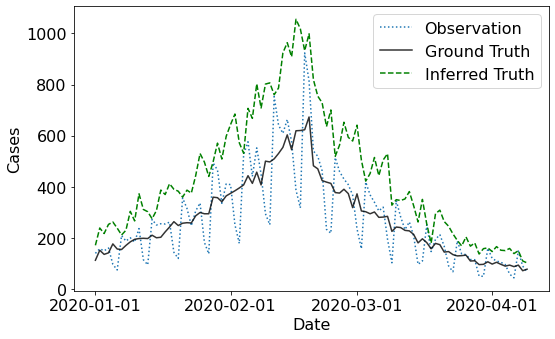

In [15]:
predicted_truth = [bias_df['Confirmed'][i] / np.mean(output['bias_' + str(int(i % 7))])
                   for i in range(0, time_steps)]  

# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
axs.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
axs.set_xticks(axs.get_xticks()[::2]);
plt.xlabel("Date"); plt.ylabel("Cases");
plt.legend();  plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"partial_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")

IndexError: list index out of range

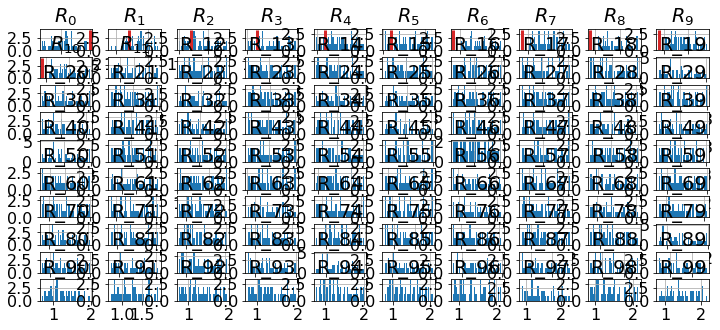

In [16]:
# axs = output.hist([name for name in output.columns if name.startswith('R_')], bins=40, figsize=(12, 5));

# for i, ax in enumerate(axs.flatten()):
#     ax.set_title("$R_{" + str(ax.get_title()[2:]) + "}$")
#     ax.vlines(x=R0_list[int((len(R0_list) - 1) * i / len(axs))], 
#               ymin=0, ymax=ax.get_ylim()[1], color='tab:red', linewidth=3)

# plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# # plt.savefig(f"../images/{images_path}"
# #                 + f"Rt_hist_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

In [ ]:
plt.rcParams['font.size'] = '15'; interval_range = 90
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


if ('R_1' in output.columns):
    for index in range(0, time_steps):
        predicted_R.append(np.mean(output['R_' + str(index)]))
        upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
        lower_R.append(np.percentile(output['R_' + str(index)], percentile))

    # Plot bias in data
    fig, ax = plt.subplots(1, figsize=(8,5))

    ax.plot(truth_df['Date'], R0_list, color='black', label = 'Ground Truth', linestyle = 'dashed')
    ax.plot(truth_df['Date'], predicted_R, color='green', label = 'Inferred Values')
    ax.fill_between(truth_df['Date'], lower_R, upper_R, color = 'green', alpha=0.2)

    ax.set_xticks(ax.get_xticks()[::2]);
    fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
    plt.xlabel("Date"); plt.ylabel("$R_{t}$")
    plt.legend(); plt.tight_layout()
    # plt.savefig(f"../images/{images_path}"
    #             + f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

## Convergence Speed

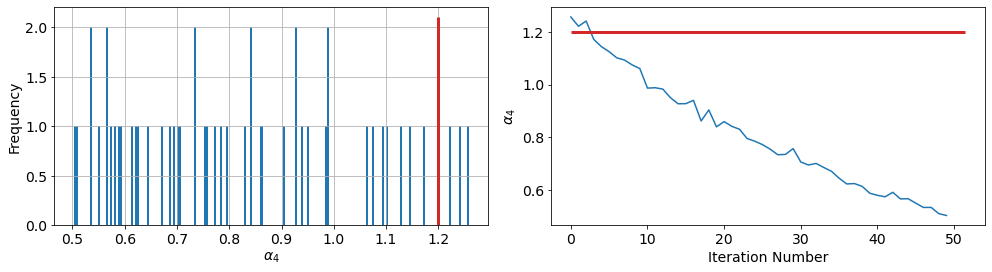

In [17]:
i = 0; bias_x = 'bias_' + str(i)
value = bias[i]; bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].vlines(x=1.2, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].hlines(y=1.2, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"../images/{images_path}"
#             + f"{bias_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

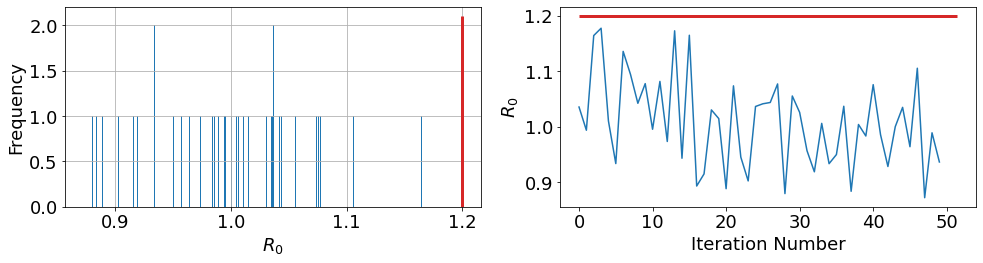

In [18]:
R_x = 'R_0'; value = 1 + R0_diff; R_name = 'R_{0}'

if (R_x in output.columns):
    plt.rcParams['font.size'] = '18'
    fig, axs = plt.subplots(1, 2, figsize=(14,4))

    histo = output.hist(R_x, ax=axs[0], bins=500)
    axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
    axs[0].set_xlabel(f'${R_name}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

    if ('Chain' in output.columns):
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            R_vals = output[R_x][output['Chain']==chain]
            axs[1].plot(index % len(index), R_vals, alpha = 0.6)
            # axs[1].plot(index % len(index), R_vals.rolling(int(2e4)).mean())
    else:
        axs[1].plot(output.index, output[R_x])
    axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
    axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(f'${R_name}$'); axs[0].set_title('');
    print

    plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
    # plt.savefig(f"../images/{images_path}"
    #             + f"{R_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

## Inferred Timeseries Accuracy

This section contains methods to quantify the accuracy of the inferred timeseries, in comparison to both the biased timeseries, and a rolling 7 day average method (the government standard).

In [19]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

RMS Residual for Biased data: 98.42
RMS Residual for Rolling Average data: 43.25
RMS Residual for Bayesian Inference data: 190.65


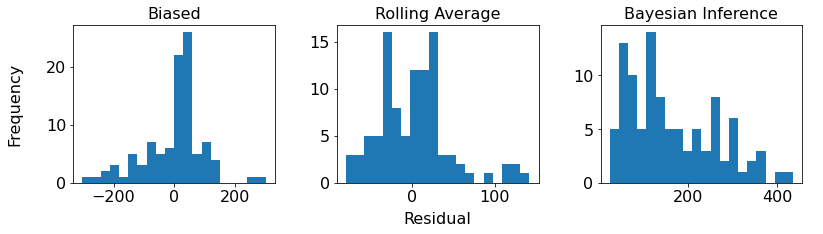

In [20]:
roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: 0.08 days
Expected lag for Rolling Average data: 1.90 days
Expected lag for Bayesian Inference data: 0.08 days


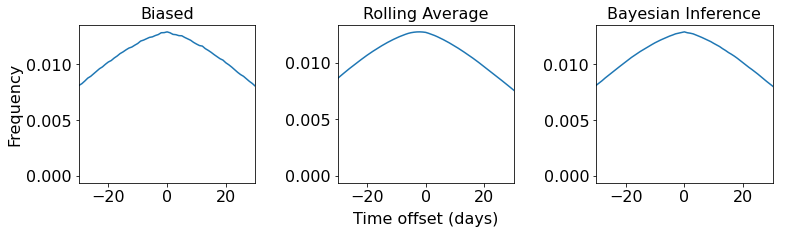

In [21]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")